In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np
import math

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional

In [2]:
device = 'cuda:0'

# The Keypoint RCNN module

In [3]:
# KeypointRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=2, num_keypoints=17, pretrained_backbone=True)
KeypointRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, progress=True)

In [9]:
def to_variable(x,requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x,requires_grad)

to_tensor = transforms.ToTensor()

def show(img): # Display rgb tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)
    
def show_gray(img): # Display grayscale tensor image
    pilTrans = transforms.ToPILImage()
    pilImg = pilTrans(img)
    s = np.array(pilImg)
    
    cv2.namedWindow( "Display window", cv2.WINDOW_AUTOSIZE)
    cv2.imshow("Display window", s)
    cv2.waitKey(0)
    
    '''
    plt.figure()
    plt.imshow(s)
    '''
    
def predict(model, img):
    im = to_tensor(img)
    im = to_variable(im.unsqueeze(0), False)
    im = im.cuda()
    im = im.to(torch.device(device))
    for i in range(50):
        out = model(im)
    del im
    torch.cuda.empty_cache()
    return out

def show_img_from_path(imgPath):
    pilImg = Image.open(imgPath)
    size = np.array(pilImg.size)
    size = np.append(size, 3).reshape(3)
    print(size)
    s = np.array(pilImg)
    plt.figure()
    plt.imshow(s)

### test

[1000  588    3]


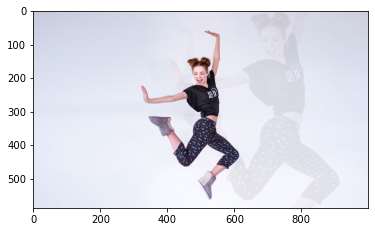

In [5]:
sample_img_path = 'test_image/1.jpg'
show_img_from_path(sample_img_path)

In [ ]:
KeypointRCNN.eval()
KeypointRCNN.to(torch.device(device))

"\nfor box in predictions[0]['boxes']:\n    if predictions[0]['scores'][idx] >= threshold:\n        rect = plt.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')\n        ax.add_patch(rect)\n    idx += 1\n\n\nbox_idx = 0\nfor dot_group in predictions[0]['keypoints']:\n    point_idx = 0\n    for dot in dot_group:\n        if predictions[0]['keypoints_scores'][box_idx][point_idx] >= kpt_score_threshold:\n            if predictions[0]['scores'][box_idx] >= threshold:\n                dot = plt.scatter(dot[0].cpu().detach().numpy(), dot[1].cpu().detach().numpy(), s=20)\n        point_idx += 1\n    box_idx += 1\n\nprint(time.time() - t_start)    \nplt.imshow(img)\n# plt.savefig(r'Sample Images\n.jpg')\n"

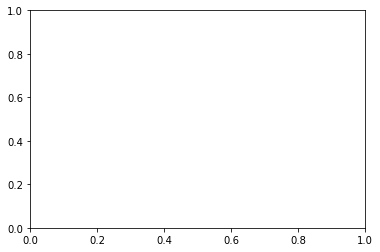

In [10]:
img = Image.open(sample_img_path)

t_start = time.time()
predictions = predict(KeypointRCNN, img)

# Get the current reference
ax = plt.gca()

threshold = 0.93
kpt_score_threshold = 5

patches = []
idx = 0

'''
for box in predictions[0]['boxes']:
    if predictions[0]['scores'][idx] >= threshold:
        rect = plt.Rectangle((box[0],box[1]),box[2],box[3],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    idx += 1


box_idx = 0
for dot_group in predictions[0]['keypoints']:
    point_idx = 0
    for dot in dot_group:
        if predictions[0]['keypoints_scores'][box_idx][point_idx] >= kpt_score_threshold:
            if predictions[0]['scores'][box_idx] >= threshold:
                dot = plt.scatter(dot[0].cpu().detach().numpy(), dot[1].cpu().detach().numpy(), s=20)
        point_idx += 1
    box_idx += 1

print(time.time() - t_start)    
plt.imshow(img)
# plt.savefig(r'Sample Images\12.jpg')
'''

# Path Object

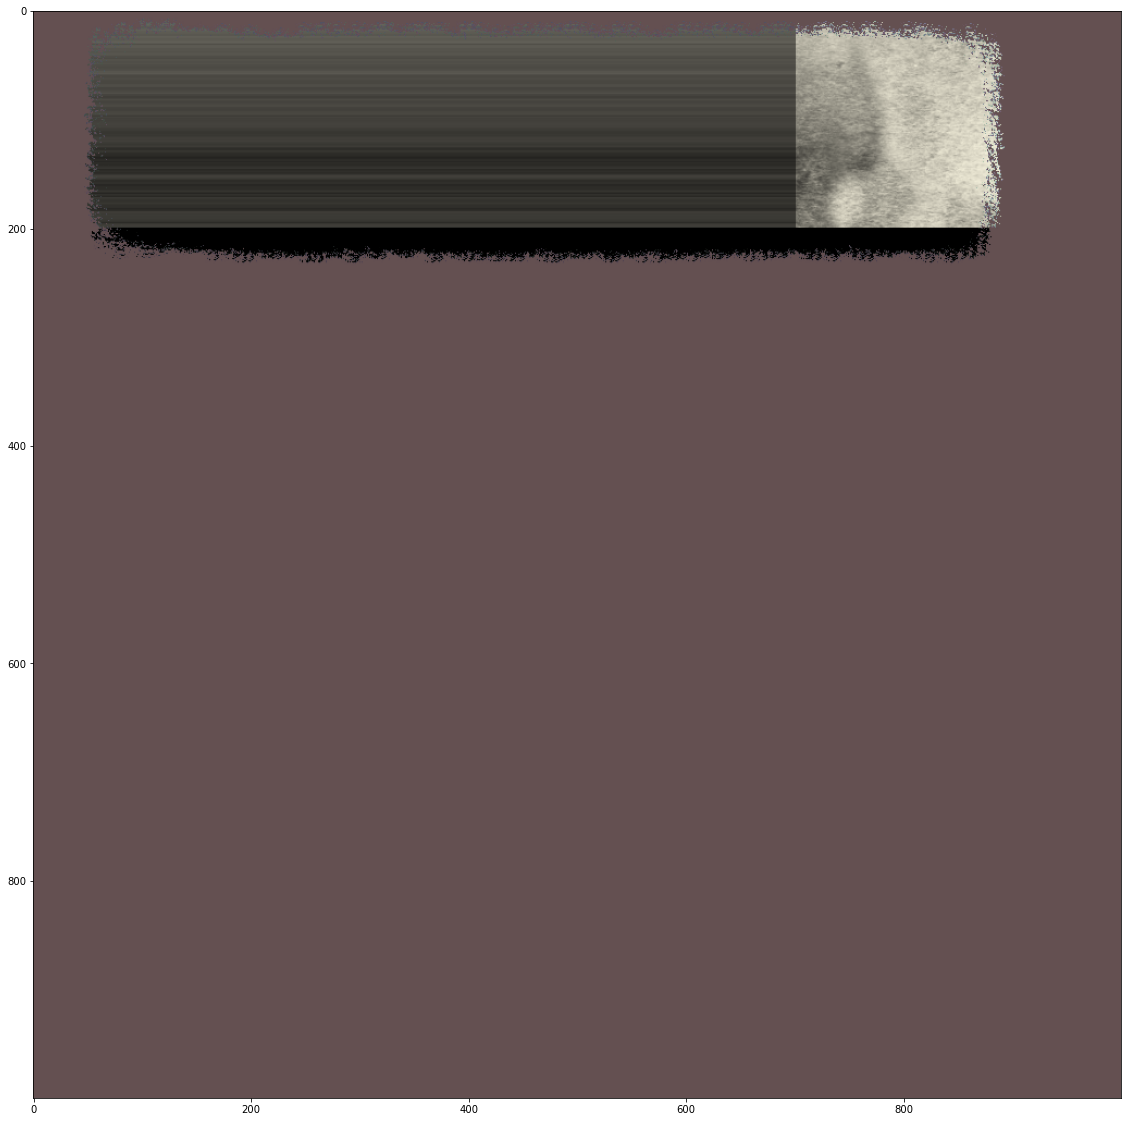

In [102]:
brush_profile = np.array([
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        ])


class Path():
    def __init__(self, map_resolution:list, temporal_decay:float, inertia_coeff:float, base_color:list):
        
        # set static coefficients
        self.base_res = map_resolution
        self.temporal_decay = temporal_decay
        self.inertia_coeff = inertia_coeff
        self.base_color = base_color

        # set  variables
        self.color = np.array([0, 0, 0])
        self.inertia = 0.0
        self.stroke_width = 0.0

        # create point lists
        self.raw_point_list = None
        self.point_list = None

        # max size of path:list
        self.path_limit = 20

        # rendered image buffer
        self.rendered_layer_buffer = []

        # renderd flag to enforce rendering after each point addition
        # this avoids issues with buffer mismatching with raw point list
        self.RENDERED = True

        # list for stroke vectoring
        self.stroke_vectors = []


    def addPoint(self, coord:list):
        # enforce rendering
        assert self.RENDERED == True, "addPoint() called before rendering"

        # get coord 
        point_x = coord[0]
        point_y = coord[1]

        # update list of points
        if self.raw_point_list is None:
            self.FIRST_DOT = True
            self.raw_point_list = np.array([point_x, point_y])
        else:
            self.FIRST_DOT = False
            self.raw_point_list = np.vstack((self.raw_point_list, np.array([point_x, point_y])))

        self.RENDERED = False

        #TODO add calculation for momentum mask


    def getStroke(self):
        # IN: list of raw points. OUT: path mask
        def points2path(points_list, Gaussian_coeff=10):
            
            def bresenham_get_line(start, end):
                """Bresenham's Line Algorithm
                Produces a list of tuples from start and end
            
                points1 = get_line((0, 0), (3, 4))
                [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
                """

                # Setup initial conditions
                x1, y1 = start
                x2, y2 = end
                dx = x2 - x1
                dy = y2 - y1
            
                # Determine how steep the line is
                is_steep = abs(dy) > abs(dx)
            
                # Rotate line
                if is_steep:
                    x1, y1 = y1, x1
                    x2, y2 = y2, x2
            
                # Swap start and end points if necessary and store swap state
                swapped = False
                if x1 > x2:
                    x1, x2 = x2, x1
                    y1, y2 = y2, y1
                    swapped = True
            
                # Recalculate differentials
                dx = x2 - x1
                dy = y2 - y1
            
                # Calculate error
                error = int(dx / 2.0)
                ystep = 1 if y1 < y2 else -1
            
                # Iterate over bounding box generating points between start and end
                y = y1
                points = []
                for x in range(x1, x2 + 1):
                    coord = (y, x) if is_steep else (x, y)
                    points.append(coord)
                    error -= abs(dy)
                    if error < 0:
                        y += ystep
                        error += dx
            
                # Reverse the list if the coordinates were swapped
                if swapped:
                    points.reverse()
                return points


            path = []
            for i, point in enumerate(self.raw_point_list):
                if i == len(self.raw_point_list) - 1 or self.FIRST_DOT:
                    break # to avoid out of bound or first dot
                else:
                    path += bresenham_get_line(point, self.raw_point_list[i+1])

            #TODO add Gaussian smooth to the list of points
            #TODO temporal decay
            # print(path) # should be a flat 2D list of pixels coord

            return np.array(path)

        #just for test
        return points2path(self.raw_point_list)


    def render(self, render_scale, bg):
        '''
        The render method takes in path (a list of xy coordinates that has already been smoothed) and
        returns stroke_layer (an HSLA 3D array)

        input: 
            path(list of coords), 
            BG(all layers below that was rendered), 
            brush shape (n by n grayscale image), 
            brush grain (m by m gray scale image),
            base color (H, S)

        1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask. 
        2. render grascale grain on to the L layer(step_size, grain size, jitter): do the same walk.
        3. render the H and S layer(): fill two layers with the same H and S values
            - have the option to render using the weighted average of base HS and BG HS instead of base HS
        4. blend the rendered HSLA layer with the baseBG layer
        '''

        def alphaBlend(top, bottom):
            '''
            takes an HSLA top and a bottom, blends and returns a HSL image
            '''
            assert top.shape[0] == 4, "top must have alpha channel"
            assert top.shape[1] == bottom.shape[1], "top and bottom must have equal shape"
            assert top.shape[2] == bottom.shape[2], "top and bottom must have equal shape"

            a = top[3] / 255
            b = 1 - a

            return np.array([top[0]*a + bottom[0]*b, top[1]*a + bottom[1]*b, top[2]*a + bottom[2]*b])


        def cleanUp():
            '''
            keep the path:list at a set length by:
                - delete coords in path that's from too long ago
                - keep a list of fully rendered layers from the delete point to the most recent render
                - update the object variable baseBG to the state at the delete point
            '''

            # trim list
            if len(self.raw_point_list) > self.path_limit:
                self.raw_point_list = self.raw_point_list[-(self.path_limit):]

            if len(self.rendered_layer_buffer) > self.path_limit:
                return self.rendered_layer_buffer.pop(0)
            else:
                return self.rendered_layer_buffer[0]


        def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


        def rotateImage(image, angle):
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            return result


        def cart2pol(x, y):
            rho = np.sqrt(x**2 + y**2)
            phi = (math.degrees(np.arctan2(y, x)) + 90)
            return(rho, phi)


        #========================================================================================

        render_res = np.array(render_scale * np.array(self.base_res), dtype=int)


        self.SHAPE_STEP_SIZE = int(1 * render_scale)
        self.GRAIN_STEP_SIZE = int(1 * render_scale)
        self.SHAPE_SIZE = int(200 * render_scale)
        self.GRAIN_SIZE_FACTOR = 1 * render_scale
        self.SHAPE_JITTER_FACTOR = 0.2 * render_scale
        self.GRAIN_JITTER_FACTOR = 0.2 * render_scale
        self.BASE_COLOR = [50, 50]
        self.COLOR_PICKUP_FACTOR = 0.0
        self.PICKUP_COLOR = True
        self.VECTOR_LEN = 25

        #TODO BG cannot have alpha channel!!!

        brush_shape = loadBrushProfile(r"I:\TRS Project 2\brush_profile\shape.jpg")
        brush_grain = loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg")

        #========================================================================================

        # create the 4 channels
        a_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #h_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #s_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        l_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)

        #========================================================================================

        #get stroke path from raw points
        self.path = self.getStroke()

        # path needs to be scaled
        self.path = self.path * render_scale

        #========================================================================================
        # calculate other parameters from path

        def calculateSpeed(raw_points, path):
            #TODO calculate spped
            return np.ones(len(path))

        def calculateAcceleration(raw_points, path):
            #TODO calculate acceleration
            return np.ones(len(path))
            
        #========================================================================================
        # 1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask.

        stepped_path = self.path[::self.SHAPE_STEP_SIZE]

        for i, pt in enumerate(stepped_path):

            # prepare brush shape
            brush_shape = cv2.resize(brush_shape, (self.SHAPE_SIZE, self.SHAPE_SIZE))

            # jitter
            jitter = np.random.randint(0, int(self.SHAPE_SIZE * self.SHAPE_JITTER_FACTOR), size=2)
            x, y = pt + jitter
            x, y = int(x), int(y)
            
            # draw the shape
            dx , dy = int(x + self.SHAPE_SIZE), int(y + self.SHAPE_SIZE)
                    
            # handle edge case
            if dx > render_res[1] - 1:
                brush_shape = brush_shape[0:int(dx - render_res[1] + 1), :]
            if dy > render_res[0] - 1:
                brush_shape = brush_shape[:, 0:int(dx - render_res[0] + 1)]

            # calculate stamp vector
            v_origin = stepped_path[i - int(render_scale * self.VECTOR_LEN)]
            v = pt - v_origin # find catesian vector between the two points
            v = cart2pol(v[0], v[1])

            #rotate the stamp
            brush_shape_rotated = brush_shape
            if i > self.VECTOR_LEN:
                brush_shape_rotated = rotate_image(brush_shape, v[1])

            # "stamp" the stroke
            # use addition here to avoid 0 overwriting 255, then cap it at 255
            a_channel[x:dx, y:dy] = a_channel[x:dx, y:dy] + brush_shape_rotated
            a_channel[x:dx, y:dy] = np.clip(a_channel[x:dx, y:dy], 0, 255)


        #========================================================================================
        # 2. render grascale grain on to the L layer(step_size, grain size, jitter): do the same walk.
        
        for i, pt in enumerate(stepped_path):

            # prepare grain map
            grain_size = self.GRAIN_SIZE_FACTOR * self.SHAPE_SIZE * np.amin([1.5, calculateSpeed(self.raw_point_list, self.path)[i]])

            # center crop grain map
            center = np.array(brush_grain.shape) / 2
            x = center[1] - grain_size/2
            y = center[0] - grain_size/2
            brush_grain = brush_grain[int(y):int(y+grain_size), int(x):int(x+grain_size)]

            # reshape back to shape size
            brush_grain = cv2.resize(brush_grain, (self.SHAPE_SIZE, self.SHAPE_SIZE))


            # jitter
            jitter = np.random.randint(0, int(self.SHAPE_SIZE * self.GRAIN_JITTER_FACTOR), size=2)
            jitter = np.zeros(2)
            x, y = pt + jitter
            x, y = int(x), int(y)
            
            # caculate area 
            dx , dy = int(x + self.SHAPE_SIZE), int(y + self.SHAPE_SIZE)
                    
            # handle edge case
            if dx > render_res[1] - 1:
                brush_grain = brush_grain[0:dx - render_res[1] + 1, :]
            if dy > render_res[0] - 1:
                brush_grain = brush_grain[:, 0:dx - render_res[0] + 1]


            # calculate stamp vector
            v_origin = stepped_path[i - int(render_scale * self.VECTOR_LEN)]
            v = pt - v_origin # find catesian vector between the two points
            v = cart2pol(v[0], v[1])

            # rotate the stamp
            brush_grain_rotated = brush_grain
            if i > self.VECTOR_LEN:
                brush_grain_rotated = rotate_image(brush_grain, v[1])


            # "stamp" the stroke
            l_channel[x:dx, y:dy] = (l_channel[x:dx, y:dy] + brush_grain_rotated) / 2
            #l_channel[x:dx, y:dy] = brush_grain

            #l_channel[x:dx, y:dy] = l_channel[x:dx, y:dy] + brush_grain
            #l_channel[x:dx, y:dy] = np.clip(l_channel[x:dx, y:dy], 0, 255)


        #========================================================================================
        # 3. render the H and S layer(): fill two layers with the same H and S values
        #     - have the option to render using the weighted average of base HS and BG HS instead of base HS


        h_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[0]) 
        s_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[1])

        if self.PICKUP_COLOR:
            s_channel = (s_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[1] * self.COLOR_PICKUP_FACTOR) / 2
            h_channel = (h_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[0] * self.COLOR_PICKUP_FACTOR) / 2

        #========================================================================================
        # 4. blend the rendered HSLA layer with the baseBG layer
        
        stroke_layer = np.vstack([[h_channel], [s_channel], [l_channel], [a_channel]])
        stroke_layer = alphaBlend(top=stroke_layer, bottom=bg)


        #========================================================================================
        # misc.

        self.rendered_layer_buffer.append(stroke_layer)
        cleanUp()
        self.RENDERED = True    
        return np.array(stroke_layer, dtype=np.uint8)


BG = np.vstack([[np.ones((1000, 1000))*179], [np.ones((1000, 1000))*50], [np.ones((1000, 1000))*100]])
testobject = Path([1000, 1000], 0.5, 10, [10,10,10])
testobject.addPoint([0, 0])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
testobject.addPoint([0, 700])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)

"""
testobject.addPoint([400, 700])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
testobject.addPoint([700, 300])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
"""

stroke_layer = np.transpose(stroke_layer, [1, 2, 0])
#cv2.imshow("img", stroke_layer)

from matplotlib.colors import hsv_to_rgb
#stroke_layer = hsv_to_rgb(stroke_layer)

stroke_layer = cv2.cvtColor(stroke_layer, cv2.COLOR_HSV2RGB)

def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (20,20))

plt.imshow(stroke_layer)
cv2.imwrite("output.jpg", cv2.cvtColor(stroke_layer, cv2.COLOR_RGB2BGR))
#plt.imshow(loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg"))
plt.show()

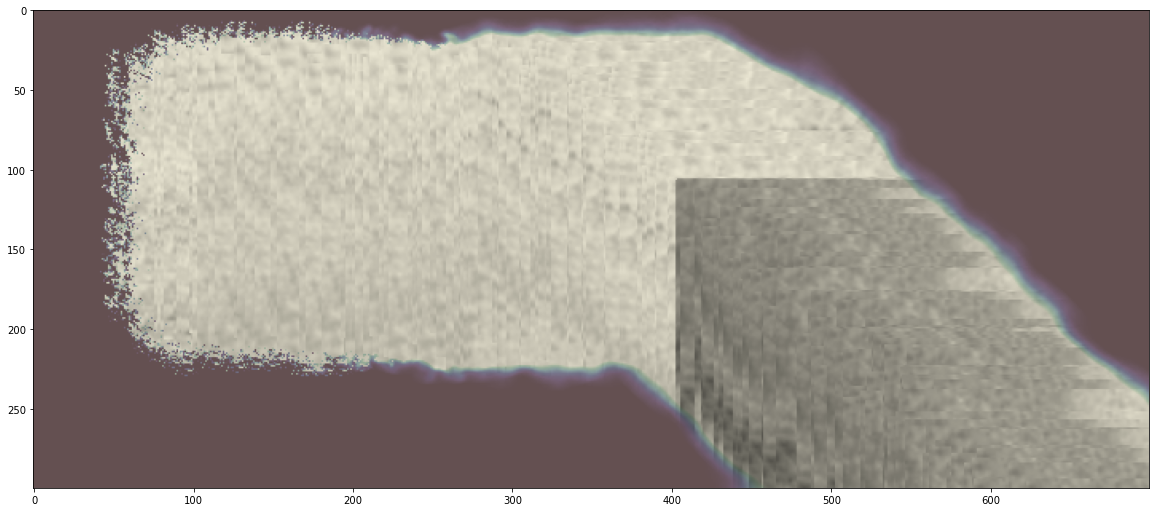

In [104]:
brush_profile = np.array([
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        ])


class Path():
    def __init__(self, map_resolution:list, temporal_decay:float, inertia_coeff:float, base_color:list):
        
        # set static coefficients
        self.base_res = map_resolution
        self.temporal_decay = temporal_decay
        self.inertia_coeff = inertia_coeff
        self.base_color = base_color

        # set  variables
        self.color = np.array([0, 0, 0])
        self.inertia = 0.0
        self.stroke_width = 0.0

        # create point lists
        self.raw_point_list = None
        self.point_list = None

        # max size of path:list
        self.path_limit = 20

        # rendered image buffer
        self.rendered_layer_buffer = []

        # renderd flag to enforce rendering after each point addition
        # this avoids issues with buffer mismatching with raw point list
        self.RENDERED = True

        # list for stroke vectoring
        self.stroke_vectors = []


    def addPoint(self, coord:list):
        # enforce rendering
        assert self.RENDERED == True, "addPoint() called before rendering"

        # get coord 
        point_x = coord[0]
        point_y = coord[1]

        # update list of points
        if self.raw_point_list is None:
            self.FIRST_DOT = True
            self.raw_point_list = np.array([point_x, point_y])
        else:
            self.FIRST_DOT = False
            self.raw_point_list = np.vstack((self.raw_point_list, np.array([point_x, point_y])))

        self.RENDERED = False

        #TODO add calculation for momentum mask


    def getStroke(self):
        # IN: list of raw points. OUT: path mask
        def points2path(points_list, Gaussian_coeff=10):
            
            def bresenham_get_line(start, end):
                """Bresenham's Line Algorithm
                Produces a list of tuples from start and end
            
                points1 = get_line((0, 0), (3, 4))
                [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
                """

                # Setup initial conditions
                x1, y1 = start
                x2, y2 = end
                dx = x2 - x1
                dy = y2 - y1
            
                # Determine how steep the line is
                is_steep = abs(dy) > abs(dx)
            
                # Rotate line
                if is_steep:
                    x1, y1 = y1, x1
                    x2, y2 = y2, x2
            
                # Swap start and end points if necessary and store swap state
                swapped = False
                if x1 > x2:
                    x1, x2 = x2, x1
                    y1, y2 = y2, y1
                    swapped = True
            
                # Recalculate differentials
                dx = x2 - x1
                dy = y2 - y1
            
                # Calculate error
                error = int(dx / 2.0)
                ystep = 1 if y1 < y2 else -1
            
                # Iterate over bounding box generating points between start and end
                y = y1
                points = []
                for x in range(x1, x2 + 1):
                    coord = (y, x) if is_steep else (x, y)
                    points.append(coord)
                    error -= abs(dy)
                    if error < 0:
                        y += ystep
                        error += dx
            
                # Reverse the list if the coordinates were swapped
                if swapped:
                    points.reverse()
                return points


            path = []
            for i, point in enumerate(self.raw_point_list):
                if i == len(self.raw_point_list) - 1 or self.FIRST_DOT:
                    break # to avoid out of bound or first dot
                else:
                    path += bresenham_get_line(point, self.raw_point_list[i+1])

            #TODO add Gaussian smooth to the list of points
            #TODO temporal decay
            # print(path) # should be a flat 2D list of pixels coord

            return np.array(path)

        #just for test
        return points2path(self.raw_point_list)


    def render(self, render_scale, bg):
        '''
        The render method takes in path (a list of xy coordinates that has already been smoothed) and
        returns stroke_layer (an HSLA 3D array)

        input: 
            path(list of coords), 
            BG(all layers below that was rendered), 
            brush shape (n by n grayscale image), 
            brush grain (m by m gray scale image),
            base color (H, S)

        1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask. 
        2. render grascale grain on to the L layer(step_size, grain size, jitter): do the same walk.
        3. render the H and S layer(): fill two layers with the same H and S values
            - have the option to render using the weighted average of base HS and BG HS instead of base HS
        4. blend the rendered HSLA layer with the baseBG layer
        '''

        def alphaBlend(top, bottom):
            '''
            takes an HSLA top and a bottom, blends and returns a HSL image
            '''
            assert top.shape[0] == 4, "top must have alpha channel"
            assert top.shape[1] == bottom.shape[1], "top and bottom must have equal shape"
            assert top.shape[2] == bottom.shape[2], "top and bottom must have equal shape"

            a = top[3] / 255
            b = 1 - a

            return np.array([top[0]*a + bottom[0]*b, top[1]*a + bottom[1]*b, top[2]*a + bottom[2]*b])


        def cleanUp():
            '''
            keep the path:list at a set length by:
                - delete coords in path that's from too long ago
                - keep a list of fully rendered layers from the delete point to the most recent render
                - update the object variable baseBG to the state at the delete point
            '''

            # trim list
            if len(self.raw_point_list) > self.path_limit:
                self.raw_point_list = self.raw_point_list[-(self.path_limit):]

            if len(self.rendered_layer_buffer) > self.path_limit:
                return self.rendered_layer_buffer.pop(0)
            else:
                return self.rendered_layer_buffer[0]


        def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


        def rotateImage(image, angle):
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            return result


        def cart2pol(x, y):
            rho = np.sqrt(x**2 + y**2)
            phi = math.degrees(np.arctan2(y, x)) + 90
            return(rho, phi)


        #========================================================================================

        render_res = np.array(render_scale * np.array(self.base_res), dtype=int)


        self.SHAPE_STEP_SIZE = int(1 * render_scale)
        self.GRAIN_STEP_SIZE = int(1 * render_scale)
        self.SHAPE_SIZE = int(200 * render_scale)
        self.GRAIN_SIZE_FACTOR = 0.5 * render_scale
        self.SHAPE_JITTER_FACTOR = 0.2 * render_scale
        self.GRAIN_JITTER_FACTOR = 0.2 * render_scale
        self.BASE_COLOR = [50, 50]
        self.COLOR_PICKUP_FACTOR = 0.0
        self.PICKUP_COLOR = True
        self.VECTOR_LEN = 100

        #TODO BG cannot have alpha channel!!!

        brush_shape = loadBrushProfile(r"I:\TRS Project 2\brush_profile\shape.jpg")
        brush_grain_original = loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg")

        #========================================================================================

        # create the 4 channels
        a_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #h_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #s_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        l_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)

        #========================================================================================

        #get stroke path from raw points
        self.path = self.getStroke()

        # path needs to be scaled
        self.path = self.path * render_scale

        #========================================================================================
        # calculate other parameters from path

        def calculateSpeed(raw_points, path):
            #TODO calculate spped
            return np.ones(len(path))

        def calculateAcceleration(raw_points, path):
            #TODO calculate acceleration
            return np.ones(len(path))
            
        #========================================================================================
        # 1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask.

        stepped_path = self.path[::self.SHAPE_STEP_SIZE]

        for i, pt in enumerate(stepped_path):

            # prepare brush shape
            brush_shape = cv2.resize(brush_shape, (self.SHAPE_SIZE, self.SHAPE_SIZE))

            # jitter
            jitter = np.random.randint(0, int(self.SHAPE_SIZE * self.SHAPE_JITTER_FACTOR), size=2)
            x, y = pt + jitter
            x, y = int(x), int(y)
            
            # draw the shape
            dx , dy = int(x + self.SHAPE_SIZE), int(y + self.SHAPE_SIZE)
                    
            # handle edge case
            if dx > render_res[1] - 1:
                brush_shape = brush_shape[0:int(dx - render_res[1] + 1), :]
            if dy > render_res[0] - 1:
                brush_shape = brush_shape[:, 0:int(dx - render_res[0] + 1)]

            # calculate stamp vector
            v_origin = stepped_path[- (i - int(render_scale * self.VECTOR_LEN)):][0]
            v = pt - v_origin # find catesian vector between the two points
            v = cart2pol(v[0], v[1])

            #rotate the stamp
            if i > self.VECTOR_LEN:
                brush_shape = rotate_image(brush_shape, v[1])

            # "stamp" the stroke
            # use addition here to avoid 0 overwriting 255, then cap it at 255
            a_channel[x:dx, y:dy] = a_channel[x:dx, y:dy] + brush_shape
            a_channel[x:dx, y:dy] = np.clip(a_channel[x:dx, y:dy], 0, 255)


            # prepare grain map
            grain_size = self.GRAIN_SIZE_FACTOR * self.SHAPE_SIZE * np.amin([1.5, calculateSpeed(self.raw_point_list, self.path)[i]])

            # center crop grain map
            def centerCrop(img, size):
                center = np.array(img.shape) / 2
                x = center[1] - size/2
                y = center[0] - size/2
                return img[int(y):int(y+size), int(x):int(x+size)]

            # rotate the stamp
            if i > self.VECTOR_LEN:
                brush_grain_rotated = rotate_image(brush_grain_original, v[1])
                brush_grain_rotated = centerCrop(brush_grain_rotated, grain_size)
            else:
                brush_grain_rotated = centerCrop(brush_grain_original, grain_size)
            

            # reshape back to shape size
            brush_grain_rotated = cv2.resize(brush_grain_rotated, (self.SHAPE_SIZE, self.SHAPE_SIZE))

            '''
            if i == 200:
                print("grain_size", grain_size)
                plt.imshow(brush_grain)
                plt.show()
                plt.imshow(brush_grain)
                plt.show()
                print("angle", v[1])'''
            # "stamp" the stroke
            
            l_channel[x:dx, y:dy] = (l_channel[x:dx, y:dy] * 0.1 + brush_grain_rotated * 0.9)
            #l_channel[x:dx, y:dy] = brush_grain

            #l_channel[x:dx, y:dy] = l_channel[x:dx, y:dy] + brush_grain
            #l_channel[x:dx, y:dy] = np.clip(l_channel[x:dx, y:dy], 0, 255)


        #========================================================================================
        # 3. render the H and S layer(): fill two layers with the same H and S values
        #     - have the option to render using the weighted average of base HS and BG HS instead of base HS


        h_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[0]) 
        s_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[1])

        if self.PICKUP_COLOR:
            s_channel = (s_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[1] * self.COLOR_PICKUP_FACTOR) / 2
            h_channel = (h_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[0] * self.COLOR_PICKUP_FACTOR) / 2

        #========================================================================================
        # 4. blend the rendered HSLA layer with the baseBG layer
        
        stroke_layer = np.vstack([[h_channel], [s_channel], [l_channel], [a_channel]])
        stroke_layer = alphaBlend(top=stroke_layer, bottom=bg)


        #========================================================================================
        # misc.

        self.rendered_layer_buffer.append(stroke_layer)
        cleanUp()
        self.RENDERED = True    
        return np.array(stroke_layer, dtype=np.uint8)


BG = np.vstack([[np.ones((1000, 1000))*179], [np.ones((1000, 1000))*50], [np.ones((1000, 1000))*100]])
testobject = Path([1000, 1000], 0.5, 10, [10,10,10])
testobject.addPoint([0, 0])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
testobject.addPoint([0, 300])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)


testobject.addPoint([400, 700])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
'''
testobject.addPoint([700, 300])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
'''

stroke_layer = np.transpose(stroke_layer, [1, 2, 0])
#cv2.imshow("img", stroke_layer)

from matplotlib.colors import hsv_to_rgb
#stroke_layer = hsv_to_rgb(stroke_layer)

stroke_layer = cv2.cvtColor(stroke_layer, cv2.COLOR_HSV2RGB)

def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (20,20))

plt.imshow(stroke_layer[:300, :700, :])
cv2.imwrite("output.jpg", cv2.cvtColor(stroke_layer, cv2.COLOR_RGB2BGR))
#plt.imshow(loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg"))
plt.show()

In [127]:
alis = [1, 2, 3]
print(alis[-10:])

[1, 2, 3]


[250 250 250]
[237 237 237]


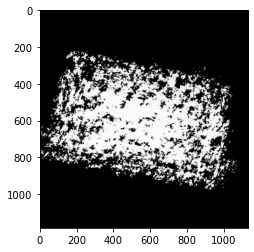

In [87]:
testim = cv2.imread(r"I:\TRS Project 2\brush_profile\shape.jpg")
print(testim[600][600])

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

testim = rotate_image(testim, 80)
print(testim[600][600])
plt.imshow(testim)

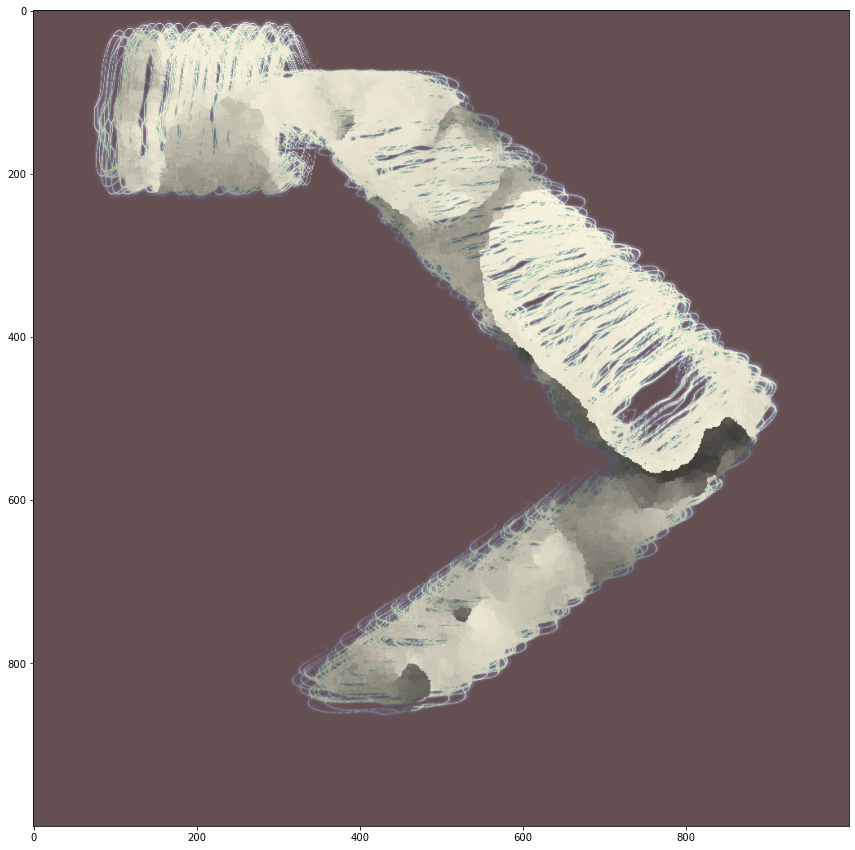

In [3]:
angle_list = []

brush_profile = np.array([
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[50, 200, 50],
            [100, 200, 100],
            [50, 100, 50]],
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        ])


class Path():
    def __init__(self, map_resolution:list, temporal_decay:float, inertia_coeff:float, base_color:list):
        
        # set static coefficients
        self.base_res = map_resolution
        self.temporal_decay = temporal_decay
        self.inertia_coeff = inertia_coeff
        self.base_color = base_color

        # set  variables
        self.color = np.array([0, 0, 0])
        self.inertia = 0.0
        self.stroke_width = 0.0

        # create point lists
        self.raw_point_list = None
        self.point_list = None

        # max size of path:list
        self.path_limit = 20

        # rendered image buffer
        self.rendered_layer_buffer = []

        # renderd flag to enforce rendering after each point addition
        # this avoids issues with buffer mismatching with raw point list
        self.RENDERED = True

        # list for stroke vectoring
        self.stroke_vectors = []


    def addPoint(self, coord:list):
        # enforce rendering
        assert self.RENDERED == True, "addPoint() called before rendering"

        # get coord 
        point_x = coord[0]
        point_y = coord[1]

        # update list of points
        if self.raw_point_list is None:
            self.FIRST_DOT = True
            self.raw_point_list = np.array([point_x, point_y])
        else:
            self.FIRST_DOT = False
            self.raw_point_list = np.vstack((self.raw_point_list, np.array([point_x, point_y])))

        self.RENDERED = False

        #TODO add calculation for momentum mask


    def getStroke(self):
        # IN: list of raw points. OUT: path mask
        def points2path(points_list, Gaussian_coeff=10):
            
            def bresenham_get_line(start, end):
                """Bresenham's Line Algorithm
                Produces a list of tuples from start and end
            
                points1 = get_line((0, 0), (3, 4))
                [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
                """

                # Setup initial conditions
                x1, y1 = start
                x2, y2 = end
                dx = x2 - x1
                dy = y2 - y1
            
                # Determine how steep the line is
                is_steep = abs(dy) > abs(dx)
            
                # Rotate line
                if is_steep:
                    x1, y1 = y1, x1
                    x2, y2 = y2, x2
            
                # Swap start and end points if necessary and store swap state
                swapped = False
                if x1 > x2:
                    x1, x2 = x2, x1
                    y1, y2 = y2, y1
                    swapped = True
            
                # Recalculate differentials
                dx = x2 - x1
                dy = y2 - y1
            
                # Calculate error
                error = int(dx / 2.0)
                ystep = 1 if y1 < y2 else -1
            
                # Iterate over bounding box generating points between start and end
                y = y1
                points = []
                for x in range(x1, x2 + 1):
                    coord = (y, x) if is_steep else (x, y)
                    points.append(coord)
                    error -= abs(dy)
                    if error < 0:
                        y += ystep
                        error += dx
            
                # Reverse the list if the coordinates were swapped
                if swapped:
                    points.reverse()
                return points


            path = []
            for i, point in enumerate(self.raw_point_list):
                if i == len(self.raw_point_list) - 1 or self.FIRST_DOT:
                    break # to avoid out of bound or first dot
                else:
                    path += bresenham_get_line(point, self.raw_point_list[i+1])

            #TODO add Gaussian smooth to the list of points
            #TODO temporal decay
            # print(path) # should be a flat 2D list of pixels coord

            return np.array(path)

        #just for test
        return points2path(self.raw_point_list)


    def render(self, render_scale, bg):
        '''
        The render method takes in path (a list of xy coordinates that has already been smoothed) and
        returns stroke_layer (an HSLA 3D array)

        input: 
            path(list of coords), 
            BG(all layers below that was rendered), 
            brush shape (n by n grayscale image), 
            brush grain (m by m gray scale image),
            base color (H, S)

        1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask. 
        2. render grascale grain on to the L layer(step_size, grain size, jitter): do the same walk.
        3. render the H and S layer(): fill two layers with the same H and S values
            - have the option to render using the weighted average of base HS and BG HS instead of base HS
        4. blend the rendered HSLA layer with the baseBG layer
        '''

        def alphaBlend(top, bottom):
            '''
            takes an HSLA top and a bottom, blends and returns a HSL image
            '''
            assert top.shape[0] == 4, "top must have alpha channel"
            assert top.shape[1] == bottom.shape[1], "top and bottom must have equal shape"
            assert top.shape[2] == bottom.shape[2], "top and bottom must have equal shape"

            a = top[3] / 255
            b = 1 - a

            return np.array([top[0]*a + bottom[0]*b, top[1]*a + bottom[1]*b, top[2]*a + bottom[2]*b])


        def cleanUp():
            '''
            keep the path:list at a set length by:
                - delete coords in path that's from too long ago
                - keep a list of fully rendered layers from the delete point to the most recent render
                - update the object variable baseBG to the state at the delete point
            '''

            # trim list
            if len(self.raw_point_list) > self.path_limit:
                self.raw_point_list = self.raw_point_list[-(self.path_limit):]

            if len(self.rendered_layer_buffer) > self.path_limit:
                return self.rendered_layer_buffer.pop(0)
            else:
                return self.rendered_layer_buffer[0]


        def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


        def rotateImage(image, angle):
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            return result


        def cart2pol(x, y):
            rho = np.sqrt(x**2 + y**2)
            phi = math.degrees(np.arctan2(y, x)) + 90
            return(rho, phi)


        #========================================================================================

        render_res = np.array(render_scale * np.array(self.base_res), dtype=int)


        self.SHAPE_STEP_SIZE = int(1 * render_scale)
        self.GRAIN_STEP_SIZE = int(1 * render_scale)
        self.SHAPE_SIZE = int(200 * render_scale)
        self.GRAIN_SIZE_FACTOR = 0.5 * render_scale
        self.SHAPE_JITTER_FACTOR = 0.2 * render_scale
        self.GRAIN_JITTER_FACTOR = 0.2 * render_scale
        self.BASE_COLOR = [50, 50]
        self.COLOR_PICKUP_FACTOR = 0.0
        self.PICKUP_COLOR = True
        self.VECTOR_LEN = 200

        #TODO BG cannot have alpha channel!!!

        brush_shape = loadBrushProfile(r"I:\TRS Project 2\brush_profile\shape2.jpg")
        brush_grain_original = loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg")

        #========================================================================================

        # create the 4 channels
        a_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #h_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        #s_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)
        l_channel = np.zeros([render_res[0], render_res[1]], dtype=np.uint16)

        #========================================================================================

        #get stroke path from raw points
        self.path = self.getStroke()

        # path needs to be scaled
        self.path = self.path * render_scale

        #========================================================================================
        # calculate other parameters from path

        def calculateSpeed(raw_points, path):
            #TODO calculate spped
            return np.ones(len(path))

        def calculateAcceleration(raw_points, path):
            #TODO calculate acceleration
            return np.ones(len(path))
            
        #========================================================================================
        # 1. render the alpha layer(step_size, brush size, jitter): walk brush shape on the mask.

        stepped_path = self.path[::self.SHAPE_STEP_SIZE]

        for i, pt in enumerate(stepped_path):

            # prepare brush shape
            brush_shape = cv2.resize(brush_shape, (self.SHAPE_SIZE, self.SHAPE_SIZE))

            # jitter
            jitter = np.random.randint(0, int(self.SHAPE_SIZE * self.SHAPE_JITTER_FACTOR), size=2)
            x, y = pt + jitter
            x, y = int(x), int(y)
            
            # draw the shape
            dx , dy = int(x + self.SHAPE_SIZE), int(y + self.SHAPE_SIZE)
                    
            # handle edge case
            if dx > render_res[1] - 1:
                brush_shape = brush_shape[0:int(dx - render_res[1] + 1), :]
            if dy > render_res[0] - 1:
                brush_shape = brush_shape[:, 0:int(dx - render_res[0] + 1)]

            # calculate stamp vector
            v_origin = stepped_path[- (i - int(render_scale * self.VECTOR_LEN)):][0]
            v = pt - v_origin # find catesian vector between the two points
            v = cart2pol(v[0], v[1])

            #rotate the stamp
            brush_shape_rotated = brush_shape
            if i > self.VECTOR_LEN:
                brush_shape_rotated = rotateImage(brush_shape, v[1])

            angle_list.append(v[1])

            # "stamp" the stroke
            # use addition here to avoid 0 overwriting 255, then cap it at 255
            a_channel[x:dx, y:dy] = a_channel[x:dx, y:dy] + brush_shape_rotated
            a_channel[x:dx, y:dy] = np.clip(a_channel[x:dx, y:dy], 0, 255)


        l_channel = cv2.resize(brush_grain_original, (render_res[0], render_res[1]))
        l_channel = cv2.xphoto.oilPainting(l_channel, 7, 1)


        #========================================================================================
        # 3. render the H and S layer(): fill two layers with the same H and S values
        #     - have the option to render using the weighted average of base HS and BG HS instead of base HS


        h_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[0]) 
        s_channel = np.full([render_res[0], render_res[1]], self.BASE_COLOR[1])

        if self.PICKUP_COLOR:
            s_channel = (s_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[1] * self.COLOR_PICKUP_FACTOR) / 2
            h_channel = (h_channel * (1 - self.COLOR_PICKUP_FACTOR) + bg[0] * self.COLOR_PICKUP_FACTOR) / 2

        #========================================================================================
        # 4. blend the rendered HSLA layer with the baseBG layer
        
        stroke_layer = np.vstack([[h_channel], [s_channel], [l_channel], [a_channel]])
        stroke_layer = alphaBlend(top=stroke_layer, bottom=bg)


        #========================================================================================
        # misc.

        self.rendered_layer_buffer.append(stroke_layer)
        cleanUp()
        self.RENDERED = True    
        return np.array(stroke_layer, dtype=np.uint8)


BG = np.vstack([[np.ones((1000, 1000))*179], [np.ones((1000, 1000))*50], [np.ones((1000, 1000))*100]])
testobject = Path([1000, 1000], 0.5, 10, [10,10,10])
testobject.addPoint([0, 0])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)
testobject.addPoint([0, 300])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)


testobject.addPoint([400, 700])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)

testobject.addPoint([700, 300])
stroke_layer = testobject.render(render_scale=1.0, bg=BG)


stroke_layer = np.transpose(stroke_layer, [1, 2, 0])
#cv2.imshow("img", stroke_layer)

from matplotlib.colors import hsv_to_rgb
#stroke_layer = hsv_to_rgb(stroke_layer)

stroke_layer = cv2.cvtColor(stroke_layer, cv2.COLOR_HSV2RGB)

def loadBrushProfile(path):
            '''
            takes a path to an image
            returns a square 2D array 0-255
            '''
            return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (15,15))

plt.imshow(stroke_layer)
cv2.imwrite("output.jpg", cv2.cvtColor(stroke_layer, cv2.COLOR_RGB2BGR))
#plt.imshow(loadBrushProfile(r"I:\TRS Project 2\brush_profile\grain2.jpg"))
plt.show()

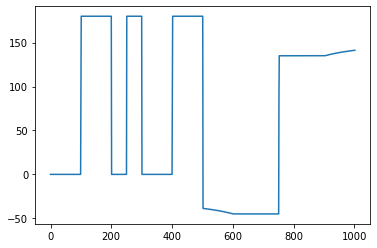

In [98]:
plt.plot(angle_list)

In [9]:
import multiprocessing
from model import getPoints

import os
import io
import time
import math
import pandas as pd
import numpy as np
import multiprocessing

import cv2
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional


if __name__ == '__main__':

    #start a queue and spwan the rcnn inference process
    send_points_event = multiprocessing.Event()

    inference_queue = multiprocessing.Queue()
    inference_process = multiprocessing.Process(target=getPoints(), args=(send_points_event))
    inference_process.start()



    while True:

        fps = int(1 / (time.time() - t_start))
        t_start = time.time()

        success, img = cap.read()

        point_list = img2points(img)

        #for dot in point_list:
            #img = cv2.circle(img, (int(dot[1]), int(dot[2])), radius=10, color=(0, 0, 255), thickness=-1)

        #Class Path Manager -- designed to handle all strokes together
        #something that would handle a list of dots from diff keypoints and spit out a rendered image
        print("adding points")
        path_manager.addPoints(point_list)
        #img = manager.render()
        print("points added!")

        
        manager = multiprocessing.Manager()
        return_dict = manager.dict()

        bottom_layer = path_manager.BG

        jobs = []
        for path in path_manager.path_dict.values():
            p = multiprocessing.Process(target=path.render, args=(1, bottom_layer))
            p.start()
            jobs.append(p)

        for job in jobs:
            job.join()


        for i in return_dict.values():
            bottom_layer = alphaBlend(top=i, bottom=bottom_layer)


        #blendLayers(BG, list of rendered stroke layers)
        #something that would combine the layers and output a single image

        bottom_layer = cv2.putText(bottom_layer, str(fps)+"fps", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color = (255, 0, 0), thickness=2)
        bottom_layer = np.transpose(bottom_layer, [2, 1, 0])
        print(bottom_layer.shape)
        cv2.imshow("image", bottom_layer)
        cv2.imwrite("video.jpg", bottom_layer)
        cv2.waitKey(1)

ImportError: cannot import name 'Client' from 'multiprocessing' (C:\ProgramData\Anaconda3\envs\pd\lib\multiprocessing\__init__.py)

In [10]:
q = multiprocessing.Queue()
q.put(1)
q.put(2)
q.put(3)
print(q.get())
print(q.get())
print(q.get())
print(q.qsize())

1
2
3
0


In [ ]:

'''    def render(self, render_resolution=None, merge=False): # here is where you can specify the upsampling resolution
        #TODO for path class, do not specify res/calculate path map until render time, just keep a list of points
        #brush also needs to be scaled before rendering (can be done through scaling the width mask)
        #maybe path objects needs to handle their own scaling (__init will have the detection res and reder will know scale)
        bottom_layer = self.BG

        if __name__ == '__main__':
            manager = multiprocessing.Manager()
            return_dict = manager.dict()

            jobs = []
            for path in self.path_dict.values():
                p = multiprocessing.Process(target=path.render, args=([1080, 1080], bottom_layer))
                jobs.append(p)
                p.start

            for job in jobs:
                job.join()


            for i in return_dict.values():
                bottom_layer = alphaBlend(top=i, bottom=bottom_layer)
            return bottom_layer'''

In [2]:
import numpy as np
a = np.array([1, 2, 3, 4, 5])
print(a[3:10])

[4 5]


In [ ]:
# handle edge case
if dx >= render_res[1]:
    brush_shape = brush_shape[0:SHAPE_SIZE - int(dx - render_res[1]), :]
if dy >= render_res[0]:
    brush_shape = brush_shape[:, 0:SHAPE_SIZE - int(dy - render_res[0])]